In [48]:
%matplotlib inline
from IPython.display import Markdown
def as_cpp(source: str):
    return Markdown(f"```c++\n{source}\n```")

In [131]:
import os
import textwrap

import matplotlib.pyplot as plt

import torch

In [132]:
shift_impl_v0_src = """
// First attempt at a specialized implementation of `x + 1`
at::Tensor shift(const at::Tensor & x) {
    TORCH_CHECK(x.scalar_type() == at::kFloat, "shift requires a float input");

    auto y = x.clone(at::MemoryFormat::Contiguous);
    auto y_ptr = x.data_ptr<float>();
    auto n = y.numel();
    for (int i = 0; i < n; i++) {
        *(y_ptr + i) += 1;
    }
    return y;
}
"""

# Compile our implementation into an inline module. Normally we would modify
# ATen instead, however this allows us to show an example without having to
# build PyTorch from source.
from torch.utils.cpp_extension import load_inline
shift_impl_v0 = load_inline(
    name='shift_impl_v0',
    cpp_sources=shift_impl_v0_src,
    extra_cflags=['-O2', '-g'],
    functions=['shift'],
)

def module_to_setup_str(m):
    """Handle importing `m` during Timer setup.

    This step is only necessary because we are using custom extensions for
    demonstration, rather than modifying and rebuilding PyTorch core.
    """
    module_dir, module_name = os.path.split(m.__file__)
    return textwrap.dedent(f"""
        import sys
        if not {repr(module_dir)} in sys.path:
            sys.path.append({repr(module_dir)})
        import {module_name[:-3]} as my_module
        """)

as_cpp(shift_impl_v0_src)

```c++

// First attempt at a specialized implementation of `x + 1`
at::Tensor shift(const at::Tensor & x) {
    TORCH_CHECK(x.scalar_type() == at::kFloat, "shift requires a float input");

    auto y = x.clone(at::MemoryFormat::Contiguous);
    auto y_ptr = x.data_ptr<float>();
    auto n = y.numel();
    for (int i = 0; i < n; i++) {
        *(y_ptr + i) += 1;
    }
    return y;
}

```

# Naive benchmark

In [21]:
import time

repeats = 5
runs_per_repeat = 100
sizes = (1, 1024, 16384)

print("x + 1")
print("".join([f"n={i}".rjust(13) for i in sizes]) + "\n" + "-" * 39)
for _ in range(repeats):
    results = ""
    for n in sizes:
        x = torch.ones((n,))
        start_time = time.time()
        for _ in range(runs_per_repeat):
            x + 1
        results += f"{(time.time() - start_time) / runs_per_repeat * 1e6:10.1f} us"
    print(results)
    
print("\n\nC++ Extension")
print("".join([f"n={i}".rjust(13) for i in sizes]) + "\n" + "-" * 39)
for _ in range(repeats):
    results = ""
    for n in sizes:
        x = torch.ones((n,))
        start_time = time.time()
        for _ in range(runs_per_repeat):
            shift_impl_v0.shift(x)
        results += f"{(time.time() - start_time) / runs_per_repeat * 1e6:10.1f} us"
    print(results)

x + 1
          n=1       n=1024      n=16384
---------------------------------------
      13.7 us       8.4 us      13.4 us
       8.8 us       7.9 us      13.3 us
       7.2 us       8.1 us      13.7 us
       7.6 us       8.9 us      13.9 us
       7.8 us       8.1 us      14.1 us


C++ Extension
          n=1       n=1024      n=16384
---------------------------------------
       4.6 us       4.6 us      16.8 us
       4.4 us       4.4 us      17.9 us
       3.8 us       5.0 us      17.1 us
       3.8 us       4.7 us      17.3 us
       3.7 us       4.9 us      17.3 us


# Slightly better: timeit.Timer

In [29]:
import timeit

print("x + 1")
print("".join([f"n={i}".rjust(13) for i in sizes]) + "\n" + "-" * 39)
for _ in range(repeats):
    results = ""
    for n in sizes:
        timer = timeit.Timer("x + 1", setup=f"import torch;x = torch.ones(({n},))")
        t = timer.timeit(runs_per_repeat) / runs_per_repeat
        results += f"{t * 1e6:10.1f} us"
    print(results)
    
print("\n\nC++ Extension")
print("".join([f"n={i}".rjust(13) for i in sizes]) + "\n" + "-" * 39)
for _ in range(repeats):
    results = ""
    for n in sizes:
        timer = timeit.Timer(
            "shift(x)", 
            setup=f"import torch;x = torch.ones(({n},))",
            globals={"shift": shift_impl_v0.shift}
        )
        t = timer.timeit(runs_per_repeat) / runs_per_repeat
        results += f"{t * 1e6:10.1f} us"
    print(results)

x + 1
          n=1       n=1024      n=16384
---------------------------------------
      12.5 us       7.9 us      14.2 us
       9.1 us       7.6 us      14.9 us
       7.0 us       7.7 us      12.6 us
      12.4 us       8.9 us      13.1 us
       7.2 us       8.1 us      13.0 us


C++ Extension
          n=1       n=1024      n=16384
---------------------------------------
       4.2 us       4.3 us      15.6 us
       5.0 us       4.5 us      16.2 us
       3.7 us       4.9 us      16.2 us
       3.5 us       4.4 us      18.6 us
       4.9 us       4.6 us      16.4 us


# Runtime aware: torch.utils.benchmark.Timer

In [43]:
from torch.utils.benchmark import Timer

m = Timer(
    stmt="x + 1",
    setup="x = torch.ones((1,))",
    sub_label="Generic implementation.",
).blocked_autorange(min_run_time=1)

# Results summarized by __repr__
print(m, "\n")

# Helper methods for statistics
print(f"Mean:   {m.mean * 1e6:6.1f} us")
print(f"Median: {m.median * 1e6:6.1f} us")
print(f"IQR:    {m.iqr * 1e6:6.1f} us")
print(f"Times:  {str(m.times[:2])[:-1]}, ..., {str(m.times[-2:])[1:]}")


x + 1: Generic implementation.
  Median: 7.08 us
  IQR:    0.34 us (6.89 to 7.23)
  142 measurements, 1000 runs per measurement, 1 thread 

Mean:      7.1 us
Median:    7.1 us
IQR:       0.3 us

(Already divided by number per run)
Raw times: [7.111713290214539e-06, 7.117092609405518e-06, ..., 6.727509200572968e-06, 6.842736154794693e-06]


In [124]:
times = []
x = [int(i) for i in torch.logspace(2, 8, 300)]
for i, n in enumerate(x):
    num_runs, total_time = timeit.Timer("x + 1", setup=f"import torch;x = torch.ones(({n},))").autorange()
    t0 = total_time / num_runs
    
    m = Timer("x + 1", f"x = torch.ones(({n},))").blocked_autorange()
    times.append((t0, m.mean, m.median))
    print(f"\r{i}", end="")

299

In [123]:
%timeit timeit.Timer().autorange()
%timeit Timer().blocked_autorange()

866 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
213 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


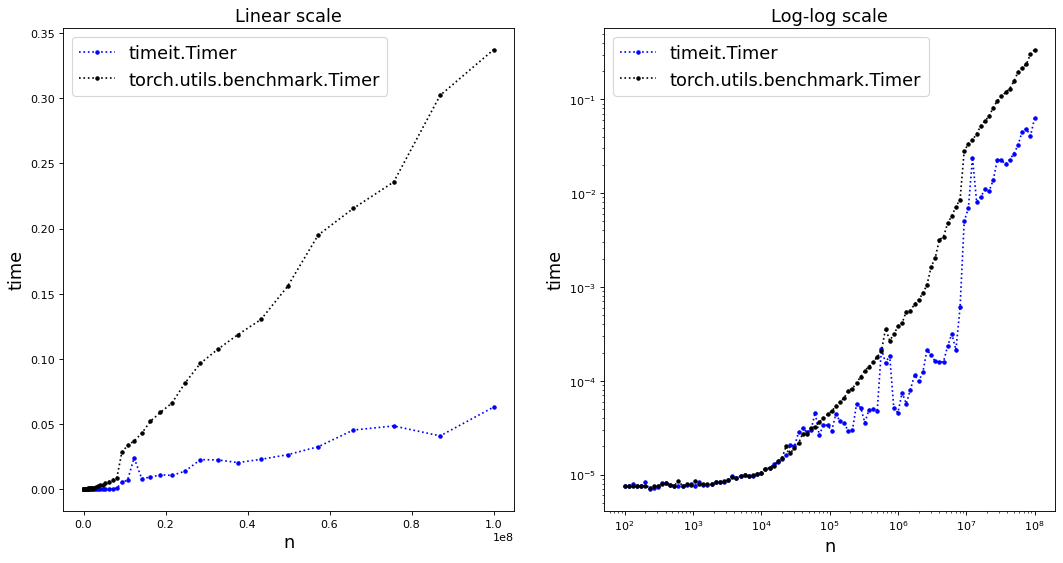

In [122]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
for i, (plot, title) in enumerate([(plt.plot, "Linear scale"), (plt.loglog, "Log-log scale")]):
    plt.subplot(1, 2, i + 1)
    plot(x, [i[0] for i in times], ".:b")
    plt.plot(x, [i[1] for i in times], ".:k")
    plt.title(title, fontsize=16)
    plt.xlabel("n", fontsize=16)
    plt.ylabel("time", fontsize=16)
    plt.legend(["timeit.Timer", "torch.utils.benchmark.Timer"], fontsize=16)

In [141]:
from torch.utils.benchmark import Compare

results = []
for n in [1, 16, 256, 1024, 4096, 16384, 32768]:
    setup=f"x = torch.ones(({n},))"
    results.append(Timer(
        "x + 1",
        setup=setup,
        label="Shift operator",
        sub_label="Generic implementation.",
        description=str(n),
    ).blocked_autorange())

    results.append(Timer(
        "my_module.shift(x)",
        setup=(
            module_to_setup_str(shift_impl_v0) +
            setup
        ),
        label="Shift operator",
        sub_label="Custom C++ operator",
        description=str(n),
    ).blocked_autorange())

compare = Compare(results)
compare.print()

[------------------------------------- Shift operator ------------------------------------]
                               |   1   |   16  |  256  |  1024  |  4096  |  16384  |  32768
1 threads: --------------------------------------------------------------------------------
      Generic implementation.  |  6.7  |  6.8  |  7.3  |  7.6   |  8.5   |   12.7  |   19.7
      Custom C++ operator      |  3.6  |  3.6  |  4.0  |  4.6   |  6.8   |   16.2  |   30.5

Times are in microseconds (us).



### With extra formatting

In [142]:
compare.trim_significant_figures()
compare.colorize()
compare.print()

[------------------------------------- Shift operator ------------------------------------]
                               |   1   |   16  |  256  |  1024  |  4096  |  16384  |  32768
1 threads: --------------------------------------------------------------------------------
      Generic implementation.  |  6.7  |  6.8  |  7.3  |  7.6   |  8.5   |    13   |    20 
      Custom C++ operator      |  3.6  |  3.6  |  4.0  |  4.6   |  6.8   |    16   |    31 

Times are in microseconds (us).

